In [26]:
import numpy as np
import pickle
import torch
from torch import nn
import collections
from model import DQN_pytorch
import time
from one_hot import onehot_target, element_set, comp_set, one_hot_to_element, element_to_one_hot, one_hot_to_comp, comp_to_one_hot, step_to_one_hot, one_hot_to_step
import seaborn as sns
import random
import matplotlib.pyplot as plt

In [2]:
# Load Q_data_random
with open('./data/Q_data_random.pkl', 'rb') as f:
    Q_data_random = pickle.load(f)

print(len(Q_data_random))

1000


In [3]:
s_material_inputs = []
s_step_inputs     = []
a_elem_inputs     = []
a_comp_inputs     = []
Q_targets         = []

for episode in Q_data_random:
    for step in episode:
        # state, action, reward = step
        [s_material, s_step], [a_elem, a_comp], Q_target = step

        s_material = torch.tensor(s_material)
        s_step = torch.tensor(s_step)
        a_elem = torch.tensor(a_elem)
        a_comp = torch.tensor(a_comp)
        Q_target = torch.tensor([Q_target])

        s_material_inputs.append(s_material)
        s_step_inputs.append(s_step)
        a_elem_inputs.append(a_elem)
        a_comp_inputs.append(a_comp)
        Q_targets.append(Q_target)

s_material_inputs = torch.stack(s_material_inputs)
s_step_inputs = torch.stack(s_step_inputs)
a_elem_inputs = torch.stack(a_elem_inputs)
a_comp_inputs = torch.stack(a_comp_inputs)
Q_targets = torch.stack(Q_targets)

print('s_material_inputs:', s_material_inputs.shape)
print('s_step_inputs:', s_step_inputs.shape)
print('a_elem_inputs:', a_elem_inputs.shape)
print('a_comp_inputs:', a_comp_inputs.shape)
print('Q_targets:', Q_targets.shape)
print('')

s_material_inputs: torch.Size([5000, 40, 115])
s_step_inputs: torch.Size([5000, 5])
a_elem_inputs: torch.Size([5000, 80])
a_comp_inputs: torch.Size([5000, 10])
Q_targets: torch.Size([5000, 1])



<AxesSubplot:>

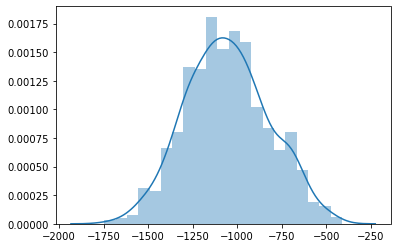

In [4]:
# Plot distribution of final rewards by random policy
final_rewards_random = Q_targets[0::5].reshape(-1) # find final rewards
sns.distplot(final_rewards_random)

In [5]:
sample_size = 5000
s_material_inputs = s_material_inputs[:sample_size,:]
s_step_inputs = s_step_inputs[:sample_size,:]
a_elem_inputs = a_elem_inputs[:sample_size,:]
a_comp_inputs = a_comp_inputs[:sample_size,:]
Q_targets = Q_targets[:sample_size,:]
print('s_material_inputs:', s_material_inputs.shape)
print('s_step_inputs:', s_step_inputs.shape)
print('a_elem_inputs:', a_elem_inputs.shape)
print('a_comp_inputs:', a_comp_inputs.shape)
print('Q_targets:', Q_targets.shape)

s_material_inputs: torch.Size([5000, 40, 115])
s_step_inputs: torch.Size([5000, 5])
a_elem_inputs: torch.Size([5000, 80])
a_comp_inputs: torch.Size([5000, 10])
Q_targets: torch.Size([5000, 1])


In [6]:
# Initialize Q network
dqn = DQN_pytorch()

# Train Q network
optimizer = torch.optim.Adam(dqn.parameters(), lr=1e-2)
loss_func = torch.nn.SmoothL1Loss().float()

start = time.time()
for epoch in range(100):
    prediction = dqn(s_material = s_material_inputs, # torch.Size([batch_size, 40, 115]) and must be .float() !!!
                    s_step      = s_step_inputs,     # torch.Size([batch_size,5])
                    a_elem      = a_elem_inputs,     # torch.Size([batch_size,80])
                    a_comp      = a_comp_inputs,  # torch.Size([batch_size,10])
                    )                    # Input x and predict based on x
    loss       = loss_func(prediction.float(), Q_targets.float()).float()   # Must be (1. nn output, 2. target)
    optimizer.zero_grad()   # Clear gradients for next train
    loss.backward()         # Backpropagation, compute gradients
    optimizer.step()        # Apply gradients
    print('Epoch = ', epoch, 'Loss = %.4f' % loss.data.numpy())
end = time.time()
print('time taken for batch:', end - start)

Epoch =  0 Loss = 864.5085
Epoch =  1 Loss = 846.8088
Epoch =  2 Loss = 806.3109
Epoch =  3 Loss = 726.8691
Epoch =  4 Loss = 592.1238
Epoch =  5 Loss = 385.7741
Epoch =  6 Loss = 190.2315
Epoch =  7 Loss = 383.3106
Epoch =  8 Loss = 404.6342
Epoch =  9 Loss = 277.2678
Epoch =  10 Loss = 188.1207
Epoch =  11 Loss = 215.7065
Epoch =  12 Loss = 272.8942
Epoch =  13 Loss = 300.2883
Epoch =  14 Loss = 292.1024
Epoch =  15 Loss = 255.8244
Epoch =  16 Loss = 209.1308
Epoch =  17 Loss = 185.2730
Epoch =  18 Loss = 207.5397
Epoch =  19 Loss = 241.3377
Epoch =  20 Loss = 241.7379
Epoch =  21 Loss = 212.0512
Epoch =  22 Loss = 187.3368
Epoch =  23 Loss = 189.2181
Epoch =  24 Loss = 205.8288
Epoch =  25 Loss = 217.2195
Epoch =  26 Loss = 214.7650
Epoch =  27 Loss = 201.2478
Epoch =  28 Loss = 187.4593
Epoch =  29 Loss = 185.1147
Epoch =  30 Loss = 194.6887
Epoch =  31 Loss = 202.6742
Epoch =  32 Loss = 198.5131
Epoch =  33 Loss = 188.1203
Epoch =  34 Loss = 183.2415
Epoch =  35 Loss = 186.9475
Ep

In [7]:
def ranked_max_actions(state, dqn, n_actions = len(element_set)*len(comp_set)):
    """
    Returns a list of ranked actions based on Q-network prodictions

    Args:
    state: List [s_material, s_step] where s_material is the string representation of material and s_step is the integer step number
    dqn: Q-network for Q-value prediction

    Returns:
    ranked_max_actions: List [[s_material, s_step, Q-value]
                              ...
                              [s_material, s_step, Q-value]
                              ]
    where s_material is the one-hot torch.tensor.float() of material and
    s_step is the  one-hot torch.tensor.float()
    1st index corresponds to highest Q-value
    """

    s_material, s_step = state
    s_material = torch.tensor(onehot_target(s_material)).float() # Get one-hot rep of s_material
    s_step = torch.tensor(step_to_one_hot([s_step])[0]).float() # Get one-hot rep of s_step

    s_material_input = torch.stack([s_material]*n_actions)
    s_step_input = torch.stack([s_step]*n_actions)

    a_elem_input = []
    a_comp_input = []
    for elem in element_set:
        a_elem = torch.tensor(element_to_one_hot([elem])[0]).float()
        for comp in comp_set:
            a_comp = torch.tensor(comp_to_one_hot([comp])[0]).float()

            a_elem_input.append(a_elem)
            a_comp_input.append(a_comp)
    
    a_elem_input = torch.stack(a_elem_input).float()
    a_comp_input = torch.stack(a_comp_input).float()
    
    Q_pred = dqn(s_material = s_material_input, # torch.Size([batch_size, 40, 115]) and must be .float() !!!
                    s_step      = s_step_input,     # torch.Size([batch_size,5])
                    a_elem      = a_elem_input,     # torch.Size([batch_size,80])
                    a_comp      = a_comp_input,  # torch.Size([batch_size,10])

                )   
    # Rank according to Q-values
    Q_pred = Q_pred.detach().numpy()
    Q_pred = Q_pred.reshape(len(element_set)*len(comp_set))
    order = Q_pred.argsort()
    ranks = order.argsort() # ranks of Q-values, 0th index = lowest Q, last index = highest Q
    
    
    a_elem_input_ranked = torch.zeros([len(element_set)*len(comp_set), len(element_set)])
    a_comp_input_ranked = torch.zeros([len(element_set)*len(comp_set), len(comp_set)])
    Q_pred_ranked = np.zeros(len(element_set)*len(comp_set))

    for rank in reversed(range(len(element_set)*len(comp_set))): # Start with most valuable
        rank_idx = ranks[rank] # rank_idx = final position
        rank_idx = (len(element_set)*len(comp_set) - 1) - rank_idx # Reverse rank_idx i.e. Want 0th index to correspond to max Q

        # Sort Q-values
        Q = Q_pred[rank]
        Q_pred_ranked[rank_idx] = Q

        # Sort a_elem according to Q-values
        a_elem = a_elem_input[rank]
        a_elem_input_ranked[rank_idx] = a_elem

        # Sort a_elem according to Q-values
        a_comp = a_comp_input[rank]
        a_comp_input_ranked[rank_idx] = a_comp

    # print(Q_pred_ranked.shape)
    # print(a_elem_input_ranked.shape)
    # print(a_comp_input_ranked.shape)
    print('Max Q: ', max(Q_pred_ranked))
    print('Min Q: ', min(Q_pred_ranked))

    return a_elem_input_ranked, a_comp_input_ranked, Q_pred_ranked


a_elem_input_ranked, a_comp_input_ranked, Q_pred_ranked = ranked_max_actions(['BaTiO3', 1], dqn = dqn)
idx = 0
# a_elem_input_ranked[idx], a_comp_input_ranked[idx], Q_pred_ranked[idx]


s_material = torch.tensor(onehot_target(
                                        'SrTiO3'
                                        )).reshape([1,40,115]).float() # Get one-hot rep of s_material
a = torch.tensor(onehot_target('SrTiO3')).reshape([1,40,115]).float()


s_step = torch.tensor(step_to_one_hot([1])[0]).reshape([1,5]).float() # Get one-hot rep of s_step

print(dqn(s_material = s_material, # torch.Size([batch_size, 40, 115]) and must be .float() !!!
          s_step     = s_step,     # torch.Size([batch_size,5])
          a_elem     = a_elem_input_ranked[799].reshape(1,80),     # torch.Size([batch_size,80])
          a_comp     = a_comp_input_ranked[799].reshape(1,10),  # torch.Size([batch_size,10])
))
print('Max a_elem: ', a_elem_input_ranked[idx])
print('Max a_comp: ', a_comp_input_ranked[idx])


# Q_pred = Q_pred.detach().numpy()
# Q_pred = Q_pred.reshape(len(element_set)*len(comp_set))
# order = Q_pred.argsort()
# ranks = order.argsort() # ranks of Q-values, 0th index = lowest Q, last index = highest Q
# ranks[71], a[71], max(a)

# Q_pred_ranked = np.zeros(len(element_set)*len(comp_set))
# for rank in reversed(range(len(element_set)*len(comp_set))): # Start with most valuable
#     rank_idx = ranks[rank] # rank_idx = index of ranks

    
#     Q = Q_pred[rank]
#     Q_pred_ranked[rank_idx] = Q
# Q_pred_ranked

Max Q:  -618.4046630859375
Min Q:  -861.444091796875
tensor([[-861.4467]], grad_fn=<AddmmBackward>)
Max a_elem:  tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])
Max a_comp:  tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])


In [24]:
from env import MaterialEnvironment, extract_data_from_ep
env = MaterialEnvironment(element_set = element_set,
                          comp_set =  comp_set,)

def generate_max_act(state, dqn):
    '''
    Generates max action.
    Args:
    a_elem_input_ranked: torch.tensor with index 0 = max a_elem and index -1 = min a_elem
    a_comp_input_ranked: torch.tensor with index 0 = max a_comp and index -1 = min a_comp

    Returns: max_a_elem, max_a_comp
    '''
    a_elem_input_ranked, a_comp_input_ranked, _ = ranked_max_actions(state = state, dqn = dqn, n_actions = len(element_set)*len(comp_set))
    max_a_elem = a_elem_input_ranked[0] # 0th index corresponds to max
    max_a_comp = a_comp_input_ranked[0] # 0th index corresponds to max

    return max_a_elem, max_a_comp

def generate_ep_with_dqn(dqn, epsilon = 0, max_steps = 5):
    '''
    Generates an episode with trained DQN
    
    Args:
    dqn: Q-network for Q-value prediction
    max_steps: Int

    Returns: 
    env.path (an episode): List of SAR data in the form of [[material, step], [element, composition], reward]
    
    '''
    env.initialize()
    # print(env.state)
    # print(env.counter)
    for i in range(max_steps):
        # if env.counter == 0: # if start of episode, choose random first element #########################
        #     env.state = random.sample(element_set, 1)[0]
        # Max action
        max_a_elem, max_a_comp = generate_max_act(state = [env.state, env.counter+1], dqn = dqn)
        max_a_elem = tuple(max_a_elem.tolist())
        max_a_comp = tuple(max_a_comp.tolist())
        action = [max_a_elem, max_a_comp]

        # Take step with action
        env.step(action)
        print('step:', env.counter)
        print('state:',env.state)
        print('reward:',env.reward())
        # print(env.num_steps_taken)
        print('')
    return env.path
generate_ep_with_dqn(dqn = dqn)

Max Q:  -617.267822265625
Min Q:  -860.3072509765625
step: 1
state: Li4
reward: 0

Max Q:  -650.7203369140625
Min Q:  -893.7598266601562
step: 2
state: Li4Li4
reward: 0

Max Q:  -752.757080078125
Min Q:  -995.79638671875
step: 3
state: Li4Li4Li4
reward: 0

Max Q:  -863.6475219726562
Min Q:  -1106.6868896484375
step: 4
state: Li4Li4Li4Li4
reward: 0

Max Q:  -943.3206176757812
Min Q:  -1186.3599853515625
step: 5
state: Li4Li4Li4Li4Li4
reward: -820.2849



[([array([[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]]),
   array([1., 0., 0., 0., 0.])],
  [(0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    1.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
  

In [9]:
# ========= FOR TRAINED POLICY ===========
start = time.time()
#Generate episodes with DQN
num_eps = 1000
episodes = []
for j in range(num_eps):
    episode = generate_ep_with_dqn(dqn = dqn)
    episodes.append(episode)

Q_data_trained = []
# Extract Q_data from episodes
for episode in episodes:
    Q_data = extract_data_from_ep(episode)
    Q_data_trained.append(Q_data)
end = time.time()
print('time taken:', end - start)

# Save Q_data
with open('./data/Q_data_trained.pkl', 'wb') as f:
    pickle.dump(Q_data_trained, f, pickle.HIGHEST_PROTOCOL)

Max Q:  -617.117919921875
Min Q:  -860.1572875976562
step: 1
state: Li4
reward: 0

Max Q:  -650.7203369140625
Min Q:  -893.7598266601562
step: 2
state: Li4Li4
reward: 0

Max Q:  -752.757080078125
Min Q:  -995.79638671875
step: 3
state: Li4Li4Li4
reward: 0

Max Q:  -863.6475219726562
Min Q:  -1106.6868896484375
step: 4
state: Li4Li4Li4Li4
reward: 0

Max Q:  -943.3206176757812
Min Q:  -1186.3599853515625
step: 5
state: Li4Li4Li4Li4Li4
reward: -820.639

Max Q:  -617.117919921875
Min Q:  -860.1572875976562
step: 1
state: Li4
reward: 0

Max Q:  -650.7203369140625
Min Q:  -893.7598266601562
step: 2
state: Li4Li4
reward: 0

Max Q:  -752.757080078125
Min Q:  -995.79638671875
step: 3
state: Li4Li4Li4
reward: 0

Max Q:  -863.6475219726562
Min Q:  -1106.6868896484375
step: 4
state: Li4Li4Li4Li4
reward: 0

Max Q:  -943.3206176757812
Min Q:  -1186.3599853515625
step: 5
state: Li4Li4Li4Li4Li4
reward: -818.86206

Max Q:  -617.117919921875
Min Q:  -860.1572875976562
step: 1
state: Li4
reward: 0

Max Q

In [10]:
# Load Q_data_random
with open('./data/Q_data_trained.pkl', 'rb') as f:
    Q_data_trained = pickle.load(f)

print(len(Q_data_trained))

1000


In [11]:
Q_targets_trained         = []

for episode in Q_data_trained:
    for step in episode:
        # state, action, reward = step
        _, _, Q_target = step
        Q_target = torch.tensor([Q_target])
        Q_targets_trained.append(Q_target)

Q_targets_trained = torch.stack(Q_targets_trained)
print('Q_targets:', Q_targets_trained.shape)
print('')

Q_targets: torch.Size([5000, 1])



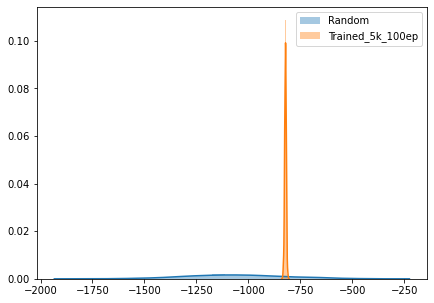

In [32]:
# Plot distribution of final rewards by random vs trained policy
final_rewards_trained = Q_targets_trained[0::5].reshape(-1) # find final rewards
plt.figure(figsize=(7,5))
sns.distplot(final_rewards_random, hist = True, norm_hist = True, label = 'Random')
sns.distplot(final_rewards_trained, hist = True, norm_hist = True, label = 'Trained_5k_100ep')
plt.legend()